# Plant Seedling Classification with Transfer Learning
Now that I've finished making a simple keras CNN, I think I'm ready to try Transfer Learning.

In [20]:
%matplotlib inline
import datetime as dt

# Import plotting for visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
#from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import numpy as np
import os.path
import pydot
import random
import itertools
import pandas as pd
from keras.applications import Xception
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.utils import layer_utils
from keras.utils import multi_gpu_model
from keras.utils.data_utils import get_file
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.applications.imagenet_utils import preprocess_input
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import sys, inspect
sys.path.append("/utils/DLWorkspace-Utils/keras-multiprocess-image-data-generator")
import tools.image as T

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # for the confusion matrix

from keras.applications.inception_v3 import InceptionV3
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import *
import os.path

from keras.applications.densenet import DenseNet201
from keras.applications.resnet50 import ResNet50

from os.path import expanduser
home = expanduser("~")

n_process = 16
import multiprocessing
pool = multiprocessing.Pool(processes=n_process)

K.set_image_data_format('channels_last')

## Reading in the dataset
First, we locate our data at the correct directories.

In [21]:
data_dir = '/data/kaggle/competitions/plant-seedlings-classification/'
train_dir = os.path.join(data_dir, 'train')
print(train_dir)
test_dir = os.path.join(data_dir, 'test')
#sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

/data/kaggle/competitions/plant-seedlings-classification/train


These are the categories we'll be using:

In [22]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)
IMAGE_SIZE = 224 # pixel height and width of each image
BATCH_SIZE = 50 

### A data augmentation algorithm
Allows me to generate more data for my NN to train on.

In [23]:
train_datagen = T.ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        pool = pool)

### Let's start with the training set.

The number of files we have per category:

In [24]:
TOTAL_PICS = 0
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))
    TOTAL_PICS += len(os.listdir(os.path.join(train_dir, category)))
print("\nTotal Number of Training images: %s" % TOTAL_PICS)

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images

Total Number of Training images: 4750


In [5]:
def read_img_train(filepath, size):
    img = image.load_img(os.path.join(train_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

In [ ]:
for category_id, category in enumerate(CATEGORIES):
    train_generator = train_datagen.flow_from_directory(
            os.path.join(train_dir, category),
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size= BATCH_SIZE,
            classes = CATEGORIES,
            shuffle=True,
            class_mode='categorical')

In [6]:
# Let's split our train and validation tests 80/20.
TRAIN_PICS = int(TOTAL_PICS * 0.8)
VALID_PICS = int(TOTAL_PICS * 0.2)
train_x = np.zeros((TRAIN_PICS, IMAGE_SIZE, IMAGE_SIZE, 3))
train_y = np.zeros((TRAIN_PICS))
valid_x = np.zeros((VALID_PICS, IMAGE_SIZE, IMAGE_SIZE, 3))
valid_y = np.zeros((VALID_PICS))
train_count = 0
valid_count = 0
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        filepath = os.path.join(category, file)
        img = read_img_train(filepath, (IMAGE_SIZE, IMAGE_SIZE))
        # randomly put images in the train or validation set
        if train_count < TRAIN_PICS:
            if random.randint(0, 9) < 8:
                train_x[train_count] = img/255
                train_y[train_count] = category_id
                train_count += 1
            else:
                if valid_count < VALID_PICS:
                    valid_x[valid_count] = img/255
                    valid_y[valid_count] = category_id
                    valid_count += 1
                else:
                    train_x[train_count] = img/255
                    train_y[train_count] = category_id
                    train_count += 1
        else:
            valid_x[valid_count] = img/255
            valid_y[valid_count] = category_id
            valid_count += 1
#train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])

#### Let's print our training and validation sets!

Train_x shape: (3800, 70, 70, 3)
Train_y shape: (3800,)


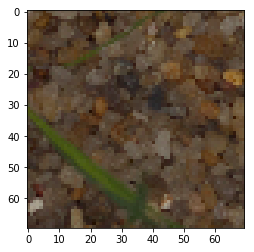

Category: 0.0
Validation set
Valid_x shape: (950, 70, 70, 3)
Valid_y shape: (950,)


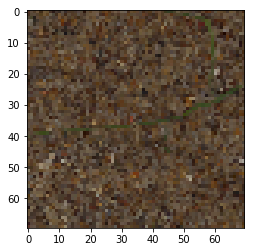

Category: 0.0


In [7]:
print("Train_x shape: " + str(train_x.shape))
print("Train_y shape: " + str(train_y.shape))
plt.imshow(train_x[0])
plt.show()
print("Category: " + str(train_y[0]))

print("Validation set")
print("Valid_x shape: " + str(valid_x.shape))
print("Valid_y shape: " + str(valid_y.shape))
plt.imshow(valid_x[0])
plt.show()
print("Category: %s" % str(valid_y[0]))

### And now the test set.

In [8]:
def read_img_test(filepath, size):
    img = image.load_img(os.path.join(test_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

In [9]:
TEST_PICS = len(os.listdir(test_dir))
test = np.zeros((TEST_PICS, IMAGE_SIZE, IMAGE_SIZE, 3))
test_ids = []
count = 0
for file in os.listdir(test_dir):
    img = read_img_test(file, (IMAGE_SIZE, IMAGE_SIZE))
    test[count] = img/255
    test_ids.append(file) # Images' ids
    count += 1
#train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])

#### Let's print our test set!

Test's shape: (794, 70, 70, 3)


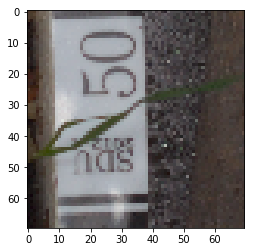

In [10]:
print("Test's shape: %s" % str(test.shape))
plt.imshow(test[0])
plt.show()

## Time for the actual model!
For now, I've just used Mehad Aria's modification of a VGG16 Net. I will need to update this to a more complicated model soon.

I was originally using Andrew Ng's example of a very simple Keras network, but that ended up being TOO simple and there was very high bias, causing the neural network to not improve at all and stay at an accuracy of about 0.05-0.08 (not very good).

The code for Andrew Ng's Keras network is as follows:
```python
    # The actual layers of the NN
    ## Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    ## CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    ## MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    ## FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(NUM_CATEGORIES, activation='sigmoid', name='fc')(X)
```

However, I am hoping that a more complex neural network will do a better job.

In [11]:
def PlantConv2DModel(input_shape):
    """
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # The actual layers of the NN
    X = Conv2D(filters=64, kernel_size=(5, 5), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), activation='relu')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = BatchNormalization(axis=3)(X)
    X = Dropout(0.1)(X)

    X = Conv2D(filters=128, kernel_size=(5, 5), activation='relu')(X)
    X = BatchNormalization(axis=3)(X)
    X = Conv2D(filters=128, kernel_size=(5, 5), activation='relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = BatchNormalization(axis=3)(X)
    X = Dropout(0.1)(X)

    X = Conv2D(filters=256, kernel_size=(5, 5), activation='relu')(X)
    X = BatchNormalization(axis=3)(X)
    X = Conv2D(filters=256, kernel_size=(5, 5), activation='relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = BatchNormalization(axis=3)(X)
    X = Dropout(0.1)(X)

    X = Flatten()(X)

    X = Dense(256, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)

    X = Dense(256, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)

    X = Dense(NUM_CATEGORIES, activation='softmax')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='PlantConv2DModel')
    
    return model

In [12]:
# Create the model
plantModel = PlantConv2DModel(train_x.shape[1:])

In [13]:
# Compile the model (I'm using Adam optimizer and categorical_crossentropy loss for now)
plantModel.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Let's get a summary of our model just to know what it's doing
plantModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
__________

In [15]:
# Fit the model on the training set (I'll just use 40 epochs and batches of size 50 for now following Andrew Ng's example)
one_hot_train_y = to_categorical(train_y)
print(str(train_x.shape))
print(str(train_y.shape))
print(str(one_hot_train_y.shape))
plantModel.fit(train_x, one_hot_train_y, epochs=20, batch_size= 75)

(3800, 70, 70, 3)
(3800,)
(3800, 12)
Epoch 1/20
3800/3800 [==============================] - 14s 4ms/step - loss: 2.6507 - acc: 0.2837
Epoch 2/20
3800/3800 [==============================] - 9s 2ms/step - loss: 1.7794 - acc: 0.4655
Epoch 3/20
3800/3800 [==============================] - 9s 2ms/step - loss: 1.2883 - acc: 0.5966
Epoch 4/20
3800/3800 [==============================] - 9s 2ms/step - loss: 1.0111 - acc: 0.6737
Epoch 5/20
3800/3800 [==============================] - 9s 2ms/step - loss: 0.8208 - acc: 0.7318
Epoch 6/20
3800/3800 [==============================] - 9s 2ms/step - loss: 0.6948 - acc: 0.7647
Epoch 7/20
3800/3800 [==============================] - 9s 2ms/step - loss: 0.6254 - acc: 0.7889
Epoch 8/20
3800/3800 [==============================] - 9s 2ms/step - loss: 0.5380 - acc: 0.8116
Epoch 9/20
3800/3800 [==============================] - 9s 2ms/step - loss: 0.4738 - acc: 0.8347
Epoch 10/20
3800/3800 [==============================] - 9s 2ms/step - loss: 0.4537 - acc

In [16]:
# Evaluate the model on the validation set
one_hot_valid_y = to_categorical(valid_y)
preds = plantModel.evaluate(valid_x, one_hot_valid_y, batch_size= 75)

print()
print ("Loss = " + str(preds[0]))
print ("Validation Accuracy = " + str(preds[1]))

950/950 [==============================] - 1s 1ms/step

Loss = 0.6356675266043136
Validation Accuracy = 0.8305263205578453


## Let's do a confusion matrix to help us understand where we went wrong.

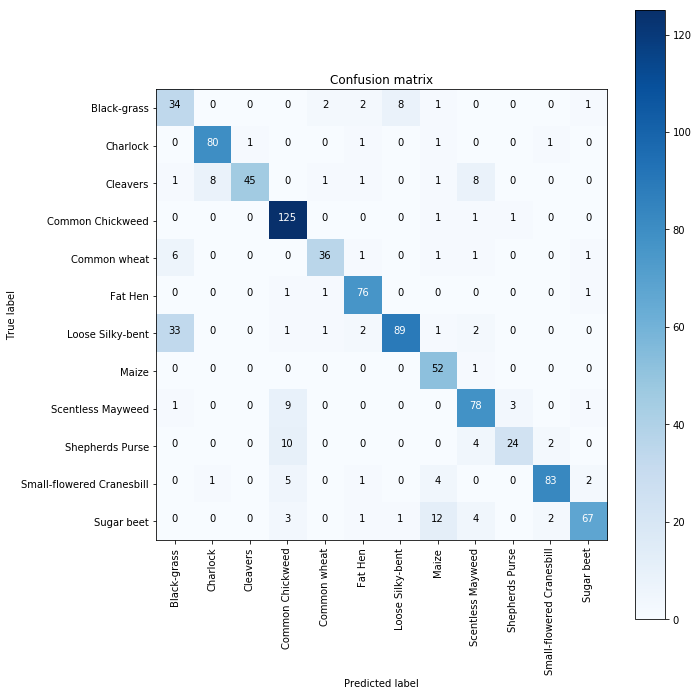

In [17]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
pred_valid_y_raw = plantModel.predict(valid_x)
pred_valid_y = np.argmax(pred_valid_y_raw, axis = 1) 
true_valid_y = np.argmax(one_hot_valid_y, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(true_valid_y, pred_valid_y) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = CATEGORIES)

## Finally time for testing!

In [18]:
test_preds = plantModel.predict(test)

# Write prediction result to a file
pred = np.argmax(test_preds, axis=1)
predStr = [CATEGORIES[c] for c in pred]

result = {'file':test_ids, 'species':predStr}
result = pd.DataFrame(result)
result.to_csv("plantPrediction.csv",index=False)
print('Prediction result saved as plantPrediction.csv')

NameError: name 'pd' is not defined